In [1]:
from itertools import product

import numpy as np
from graspy.simulations import er_np, sbm
from graspy.plot import heatmap
from graspy.utils import symmetrize
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def generate_pop(m, loc=0, nodes=5):
    scale = 1/2.576
    
    arrs  = []
    for _ in np.arange(m):
        values = []
        for _ in range((nodes * (nodes - 1)) // 2):
            value = np.random.normal(loc, scale)
            while (value > 1) or (value < -1):
                value = np.random.normal(loc, scale)
            values.append(value)
            
        arr = np.zeros(shape=(nodes, nodes))
        arr[np.triu_indices(nodes, k=1)] = values
        arr = symmetrize(arr, method='triu')
        
        arrs.append(np.array(arr))
        
    out = np.stack(arrs)
    return out

def generate_data(m, delta=0, seed=None):
    np.random.seed(seed)
    
    pop1 = generate_pop(m, loc=0)
    pop2 = generate_pop(m, loc=delta)
    
    return pop1, pop2

def compute_pvalue(pop1, pop2):
    _, pvals = ttest_ind(pop1, pop2, axis=0)
    np.nan_to_num(pvals, copy=False)
    
    return pvals

def compute_trustworthiness(pvals):
    idx = np.triu_indices(pvals.shape[0], k=1)
    res = pvals[idx]
    
    fraction_correct = (res <=0.05).mean()
    all_correct = np.all(res <= 0.05)
    
    return fraction_correct, all_correct

In [3]:
def run_experiment(m, delta, seed, reps):
    fraction_corrects = []
    all_corrects = []
    
    for i in range(reps):
        pop1, pop2 = generate_data(m = m, delta=delta, seed = seed+i)
        pvals = compute_pvalue(pop1, pop2)
        
        fraction_correct, all_correct = compute_trustworthiness(pvals)
        
        fraction_corrects.append(fraction_correct)
        all_corrects.append(all_correct)
    
    to_append = [delta, m, np.mean(fraction_corrects), np.mean(all_corrects)]

    return to_append

In [4]:
deltas = np.linspace(0, 1, 100)
ms = np.linspace(10, 1000, 100)
reps=500

In [5]:
args = [(m, delta, seed*reps, reps) for seed, (m, delta) in enumerate(product(ms, deltas))]

res = Parallel(n_jobs=-2, verbose=1)(
    delayed(run_experiment)(
        *arg
    ) for arg in args
)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 47 concurrent workers.
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-2)]: Done 356 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-2)]: Done 706 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 1156 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-2)]: Done 1706 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-2)]: Done 2356 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-2)]: Done 3106 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-2)]: Done 3956 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-2)]: Done 4906 tasks      | elapsed: 75.3min
[Parallel(n_jobs=-2)]: Done 5956 tasks      | elapsed: 112.5min
[Parallel(n_jobs=-2)]: Done 7106 tasks      | elapsed: 160.6min
[Parallel(n_jobs=-2)]: Done 8356 tasks      | elapsed: 218.9min
[Parallel(n_jobs=-2)]: Done 9706 tasks      | elapsed: 293.0min
[Parallel(n_jobs=-2)]: Done 10000 out of 10000 | elapsed: 309.5min finished


In [6]:
cols =  ['delta', 'm', 'fraction_correct', 'all_correct']
res_df = pd.DataFrame(res, columns = cols) 

In [9]:
res_df.to_csv("j1c-experiment2-results.csv", index=False)

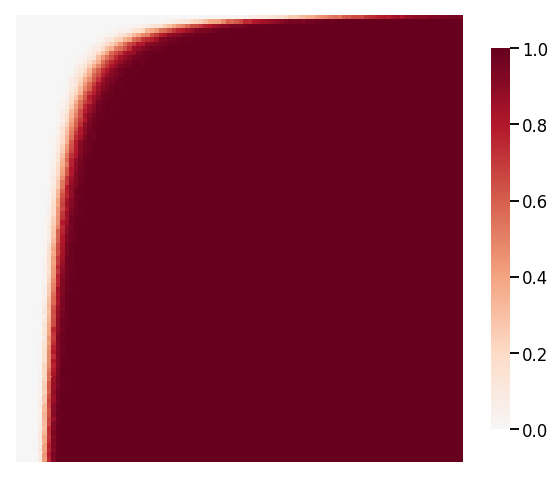

In [10]:
heatmap(res_df.all_correct.values.reshape(100, -1))

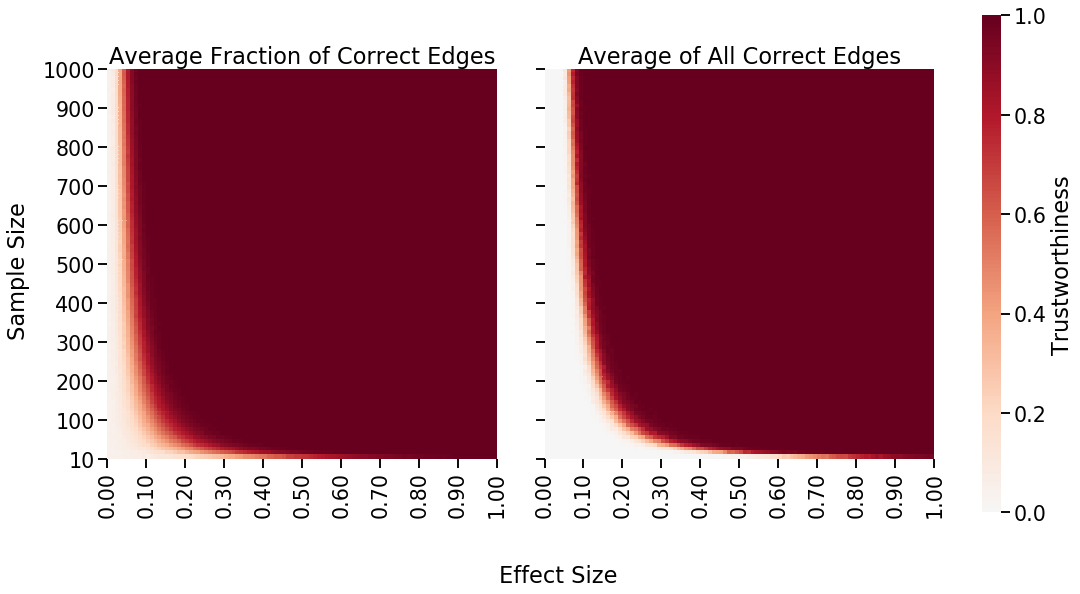

In [17]:
samples = np.arange(0, 1001, 100)
samples[0] += 10
samples = [str(i) for i in samples]

fmt = lambda x: "{:.2f}".format(x)
with sns.plotting_context('talk', font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 0.05]}, figsize=(15, 8))
    
    sns.heatmap(
        np.flipud(res_df.fraction_correct.values.reshape(100, -1)),
        ax = ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[fmt(i) for i in np.linspace(0, 1, 101)[::10]],
        yticklabels=samples,
        cbar_ax=ax[-1]
    )
    ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1]+1, 10))
    ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0]+1, 10)[::-1])
    ax[0].set_title("Average Fraction of Correct Edges")
    
    sns.heatmap(
        np.flipud(res_df.all_correct.values.reshape(100, -1)),
        ax = ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7, label='Trustworthiness'),
        xticklabels=[fmt(i) for i in np.linspace(0, 1, 101)[::10]],
        cbar_ax=ax[-1]
    )
    ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("Average of All Correct Edges")


    fig.text(-0.01, 0.5, "Sample Size", va='center', rotation='vertical')
    fig.text(0.5, -0.03, "Effect Size", va='center', ha='center')
    
    fig.tight_layout()